# 2:1 MENT — toy problem

In [1]:
import os
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt

import ment
import ment.train
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["colorbar.width"] = "1.2em"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "galaxy"
ndim = 2
n_meas = 6
n_bins = 80
xmax = 6.0
seed = 0

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed, normalize=True)
x_true = dist.sample(1_000_000)

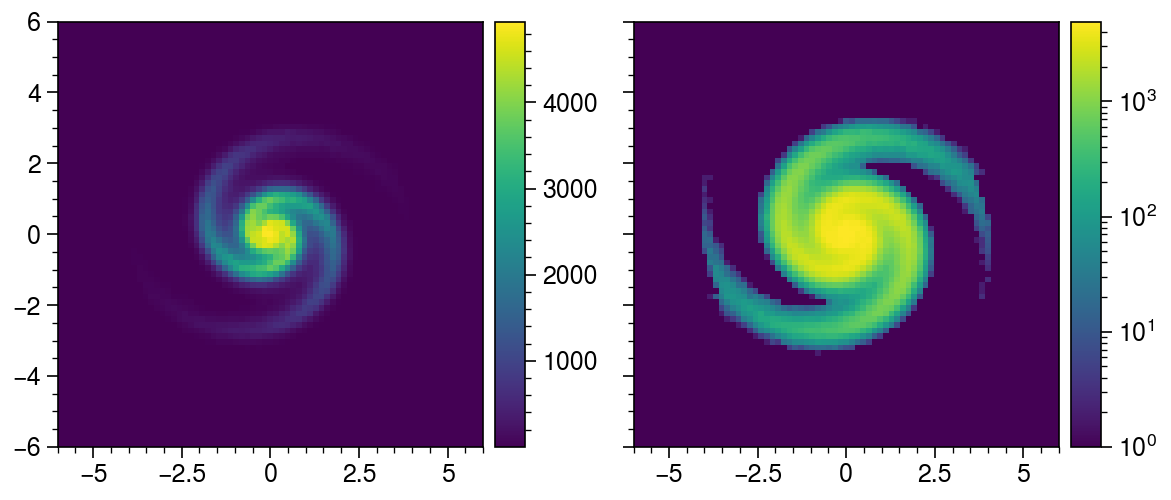

In [5]:
limits = 2 * [(-xmax, xmax)]

fig, axs = plt.subplots(ncols=2, figheight=2.5)
for i, ax in enumerate(axs):
    hist, edges = np.histogramdd(x_true, bins=75, range=limits)
    psv.plot(
        x_true,
        limits=limits,
        bins=75,
        offset=1.0,
        norm=("log" if i else None),
        colorbar=True,
        ax=ax,
    )

## Data generation

In [6]:
phase_advances = np.linspace(0.0, np.pi, n_meas, endpoint=False)

transfer_matrices = []
for phase_advance in phase_advances:
    matrix = ment.sim.rotation_matrix(phase_advance)
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

bin_edges = np.linspace(-xmax, xmax, n_bins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(axis=0, edges=bin_edges)
    projections.append([projection])

projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
prior = ment.GaussianPrior(ndim=2, scale=1.0)

samp_grid_limits = limits
samp_grid_shape = ndim * [200]
sampler = ment.samp.GridSampler(grid_limits=samp_grid_limits, grid_shape=samp_grid_shape)

integration_limits = [(-xmax, xmax)]
integration_limits = [integration_limits for transform in transforms]
integration_size = 200

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=1_000_000,
    integration_limits=integration_limits,
    integration_size=integration_size,
    verbose=True,
)

## Training

In [8]:
def plot_model(model):
    figs = []

    # Plot reconstructed vs. true distribution.
    x_pred = model.sample(1_000_000)

    fig, axs = plt.subplots(ncols=2, figheight=2.5)
    for i, ax in enumerate(axs):
        psv.plot(
            x_pred,
            limits=limits,
            bins=128,
            offset=1.0,
            norm=("log" if i else None),
            colorbar=True,
            discrete=False,
            ax=ax,
        )
    figs.append(fig)

    # Plot simulated vs. measured projections.
    projections_true = model.projections
    projections_pred = ment.sim.simulate(x_pred, model.transforms, model.diagnostics)

    ncols = min(n_meas, 7)
    nrows = int(np.ceil(n_meas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index, ax in enumerate(axs):
            transform = transforms[index]
            projection = unravel(model.projections)[index]
            diagnostic = unravel(model.diagnostics)[index]

            diagnostic(transform(x_pred))

            coords_pred = diagnostic.coords
            coords_meas = projection.coords

            values_pred = diagnostic.values
            values_meas = projection.values
            scale = np.max(values_meas)

            ax.plot(coords_meas, values_meas / scale, color="lightgray")
            ax.plot(coords_pred, values_pred / scale, color="black", marker=".", lw=0, ms=1.0)
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


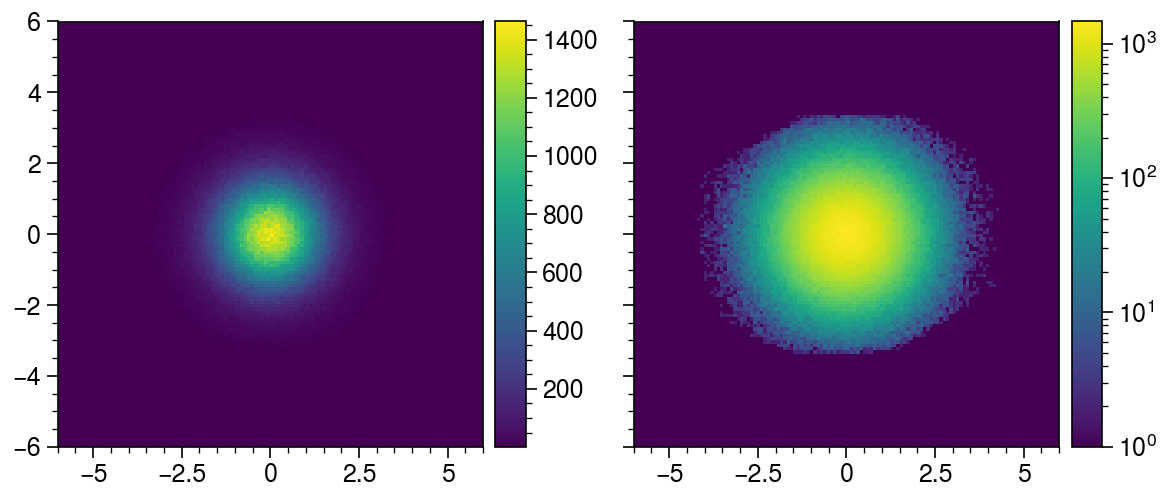

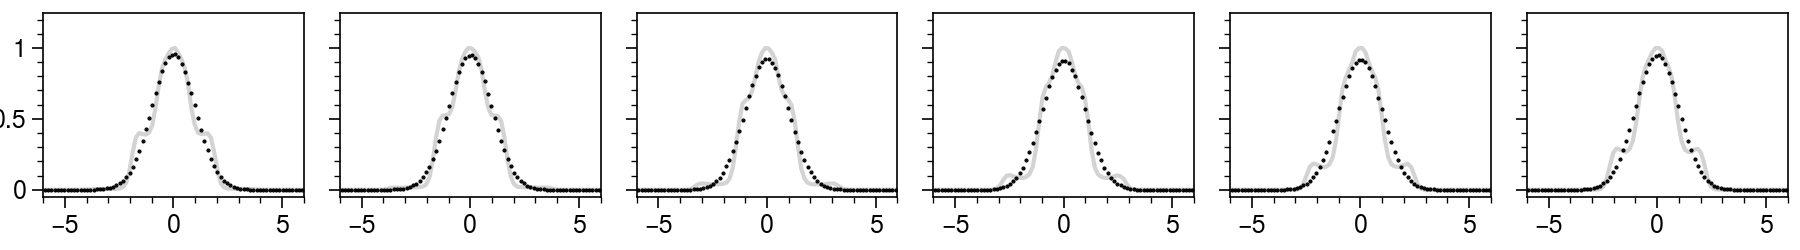

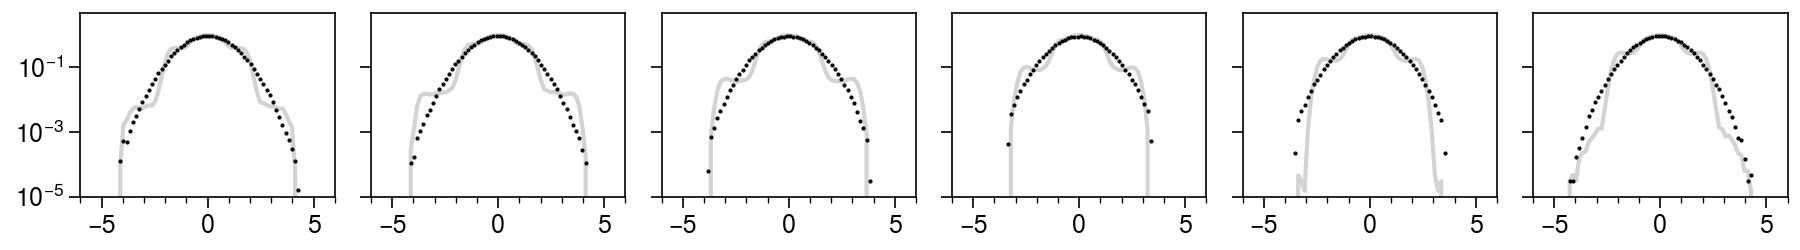

None
epoch = 1
transform=0
diagnostic=0
transform=1
diagnostic=0


transform=2
diagnostic=0
transform=3
diagnostic=0


transform=4
diagnostic=0
transform=5
diagnostic=0


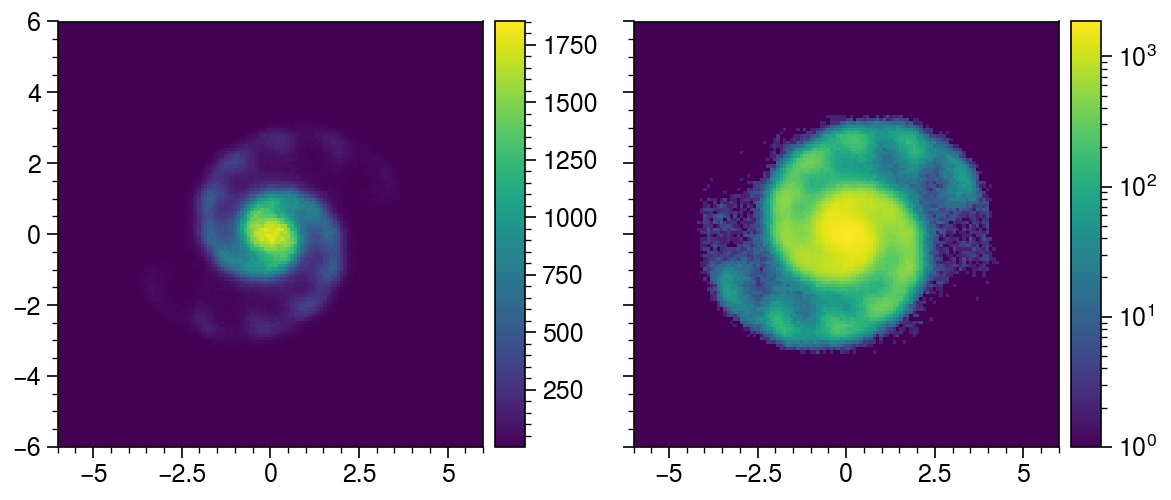

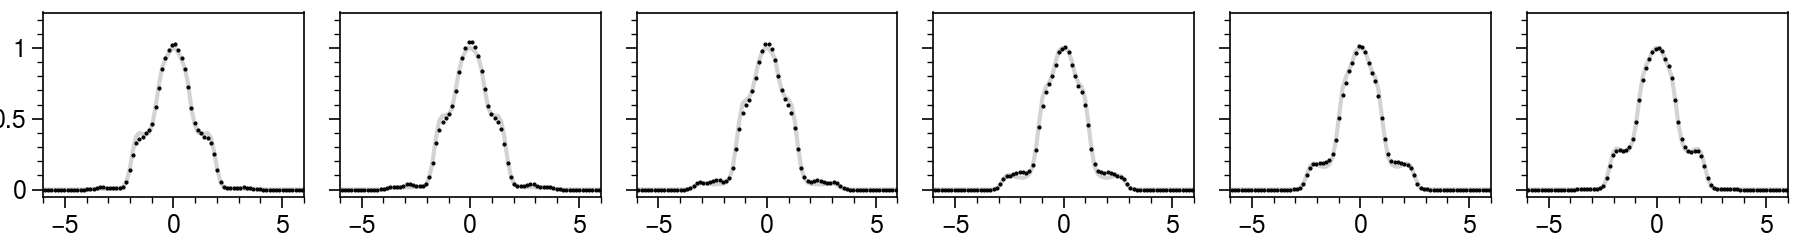

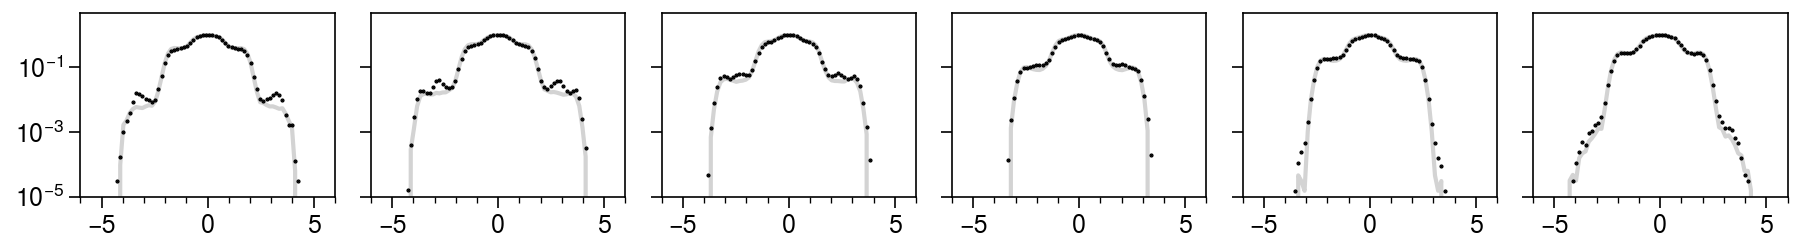

None
epoch = 2
transform=0
diagnostic=0
transform=1
diagnostic=0


transform=2
diagnostic=0
transform=3
diagnostic=0


transform=4
diagnostic=0
transform=5
diagnostic=0


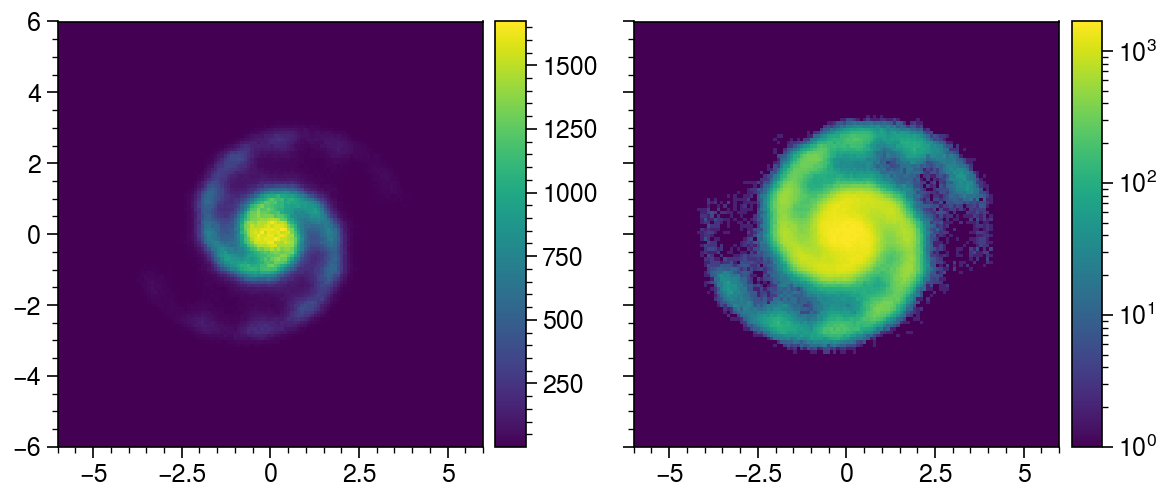

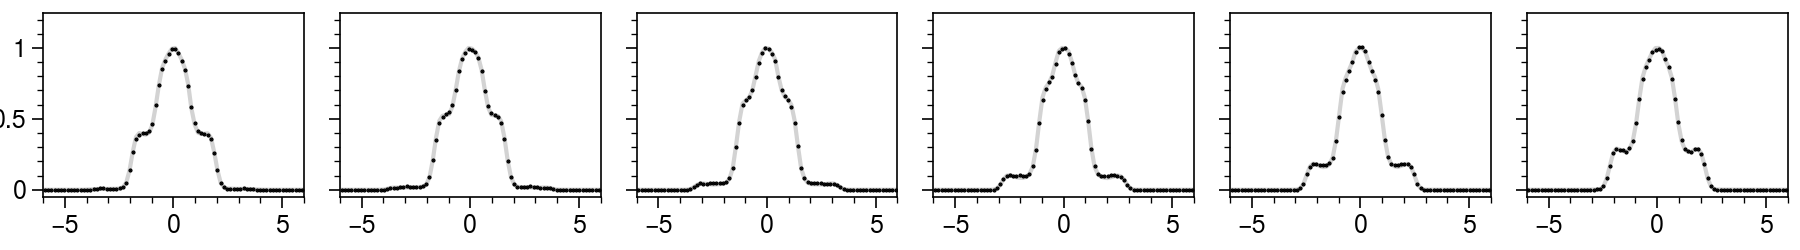

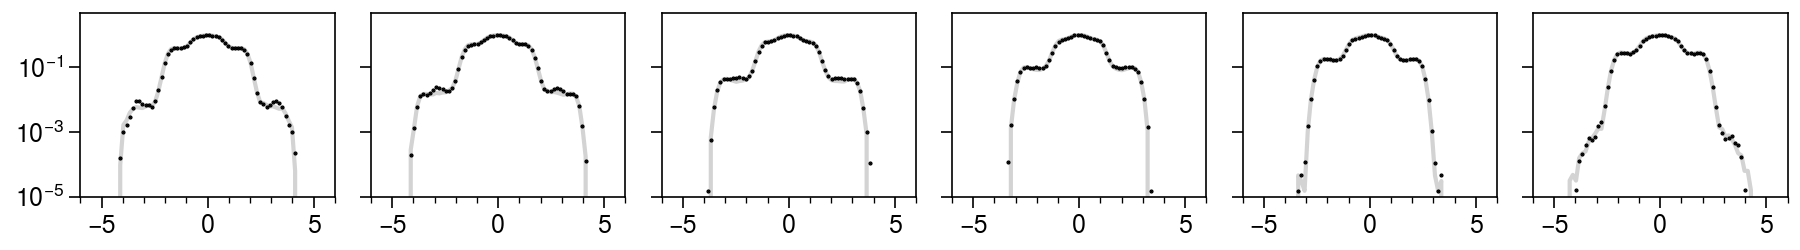

None
epoch = 3
transform=0
diagnostic=0
transform=1
diagnostic=0


transform=2
diagnostic=0
transform=3
diagnostic=0


transform=4
diagnostic=0
transform=5
diagnostic=0


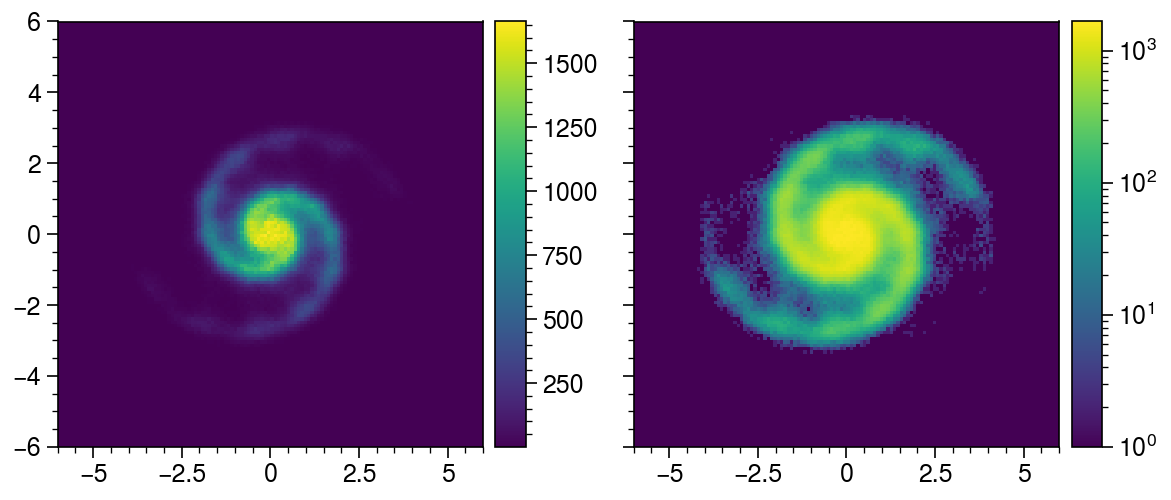

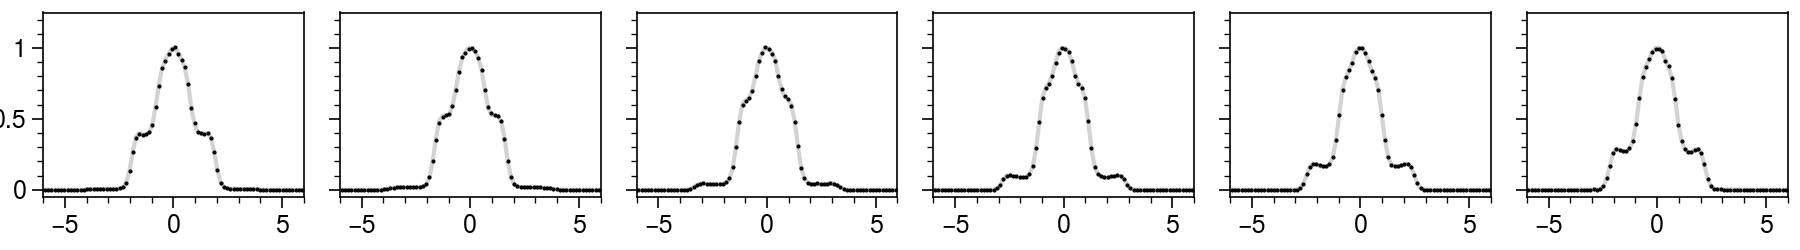

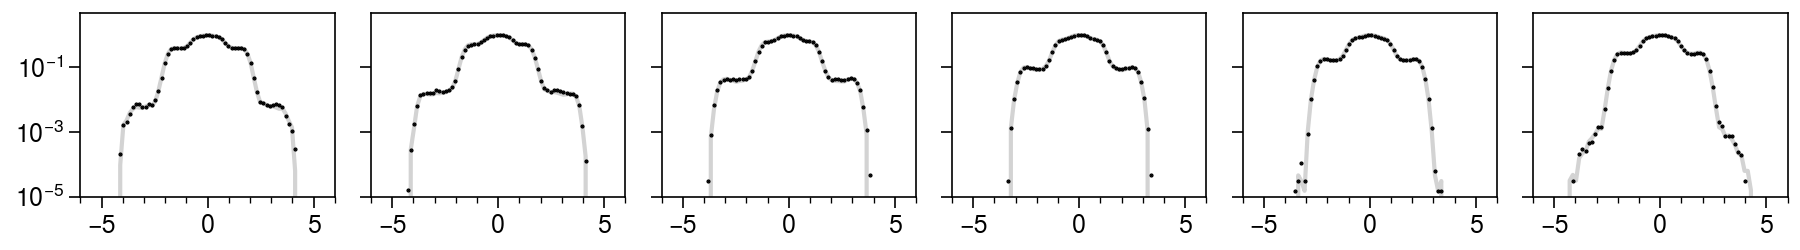

None
epoch = 4
transform=0
diagnostic=0
transform=1
diagnostic=0


transform=2
diagnostic=0
transform=3
diagnostic=0


transform=4
diagnostic=0
transform=5
diagnostic=0


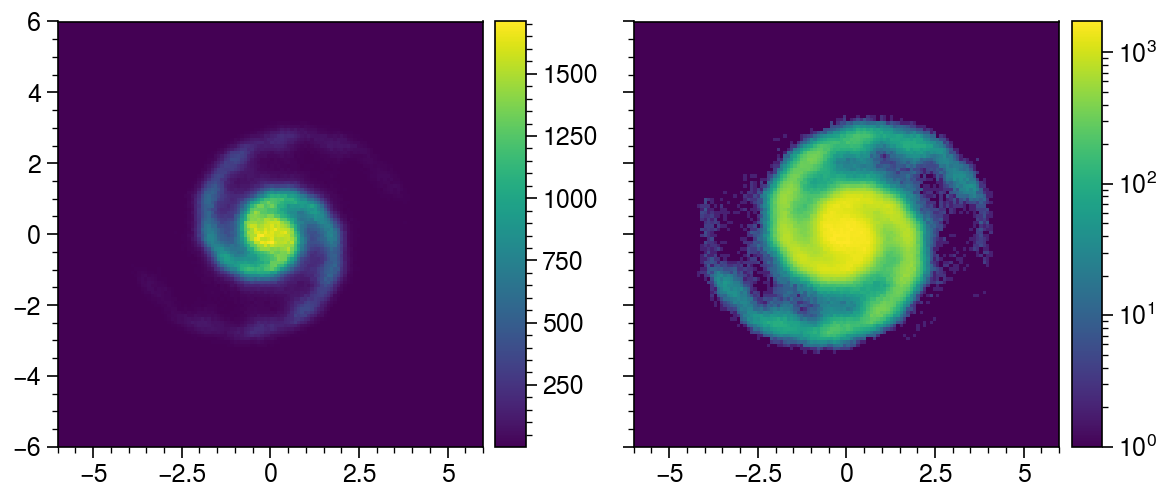

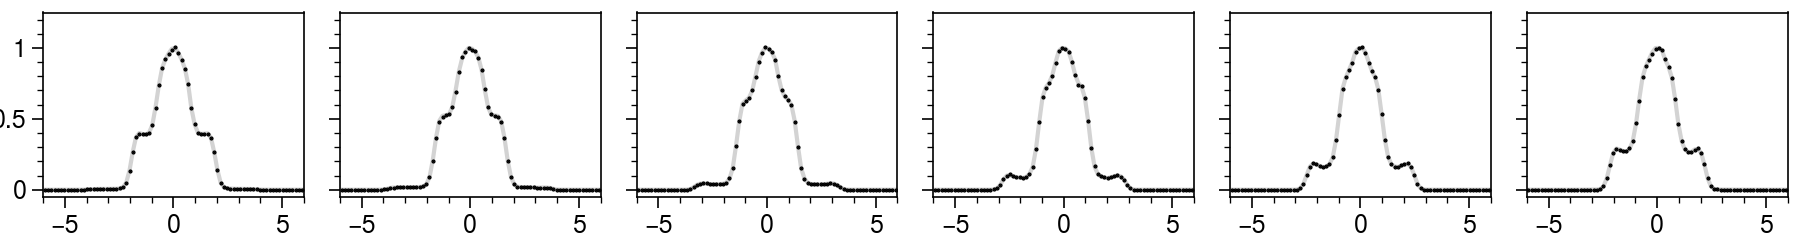

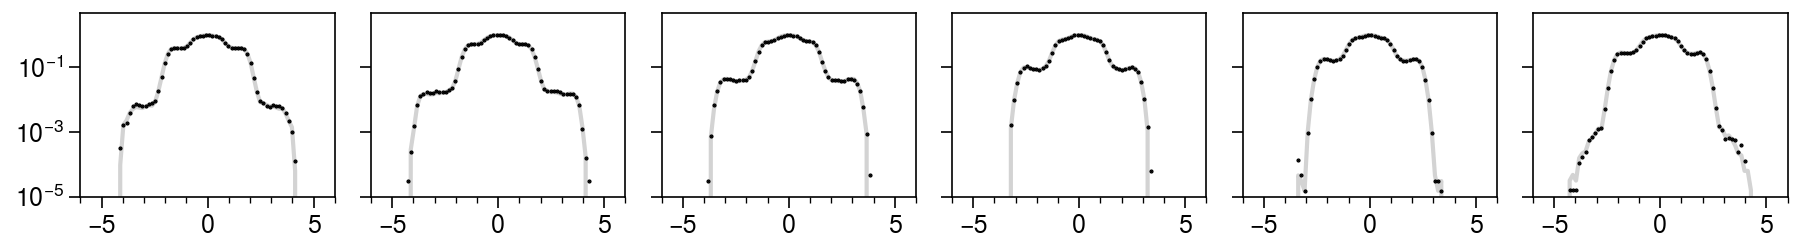

None


In [9]:
model.mode = "sample"

trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=4, learning_rate=0.90)